## Error calculations

Error due to seperation between INTEGRAL and Earth.

In [1]:
D = 150e3 # max distance between INTEGRAL and Earth (~ 150 000 km)
r = 4 * 149597870.7 # min distance between Jupiter and Earth is ~ 4 AU 

error = D/r * 206265/60 # convert to arcmin
print("Angular error is ", error, " arcmin") # below 1', insignificant (FWHM is 12' for INTEGRAL)

Angular error is  0.8617477267341882  arcmin


Error due to seperation between INTEGRAL and Earth is negligible.

In [3]:
error = 0.8617477267341882 # arcmin error due to distance between INTEGRAL and Earth
pixel_scale_arcmin = 0.082286 * 60 # arcmin pixel scale (taken from the header of a queried image)
print(error/pixel_scale_arcmin, "pixels")
print("Pixel scale is ", pixel_scale_arcmin, " arcmin/pixel", "or ", pixel_scale_arcmin/60, " degrees/pixel", "or ", pixel_scale_arcmin*60, " arcsec/pixel")

# for jem-x
pixel_scale_arcmin = 0.026 * 60 # arcmin pixel scale (taken from the header of a queried image)
print(error/pixel_scale_arcmin, "pixels")
print("Pixel scale is ", pixel_scale_arcmin, " arcmin/pixel", "or ", pixel_scale_arcmin/60, " degrees/pixel", "or ", pixel_scale_arcmin*60, " arcsec/pixel")

0.17454320433896983 pixels
Pixel scale is  4.9371599999999995  arcmin/pixel or  0.082286  degrees/pixel or  296.22959999999995  arcsec/pixel
0.552402388932172 pixels
Pixel scale is  1.5599999999999998  arcmin/pixel or  0.026  degrees/pixel or  93.6  arcsec/pixel


## Jupiter ScWs

In [3]:
from astropy.coordinates import SkyCoord
from astroquery.jplhorizons import Horizons
import pandas as pd
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
import astropy.units as u

Load the ScWs.

In [4]:
scw_ids = []
scw_versions = []
scw_start_times = []
scw_end_times = []
jupiter_ra = []
jupiter_dec = []

with open("../data/2003-01-01_2025-01-01.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw_ids.append(parts[0])
        scw_versions.append(parts[1])
        scw_start_times.append(float(parts[2]))  
        scw_end_times.append(float(parts[3]))  
        jupiter_ra.append(float(parts[4]))  
        jupiter_dec.append(float(parts[5]))  

# Sort by time and remove duplicates
unique_sorted_data = {}
for sid, ver, start, end, ra, dec in sorted(zip(scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec), key=lambda x: x[0]):
    if sid not in unique_sorted_data:  
        unique_sorted_data[sid] = (sid, ver, start, end, ra, dec)

scw_ids, scw_versions, scw_start_times, scw_end_times, jupiter_ra, jupiter_dec = map(list, zip(*unique_sorted_data.values()))

In [5]:
scw_list = [id + "." + ver for id, ver in zip(scw_ids, scw_versions)]
scw_durations = [(end - start)*24*60 for start, end in zip(scw_start_times, scw_end_times)]

Plot distribution of the ScWs over time and the angular seperation between the Crab and the Sun.

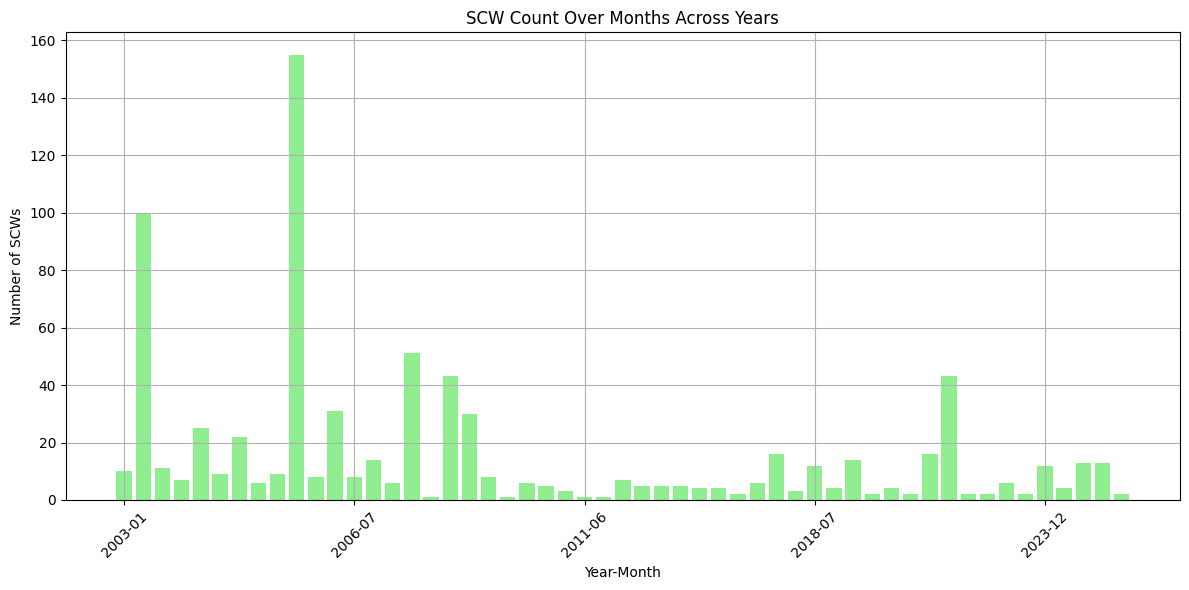

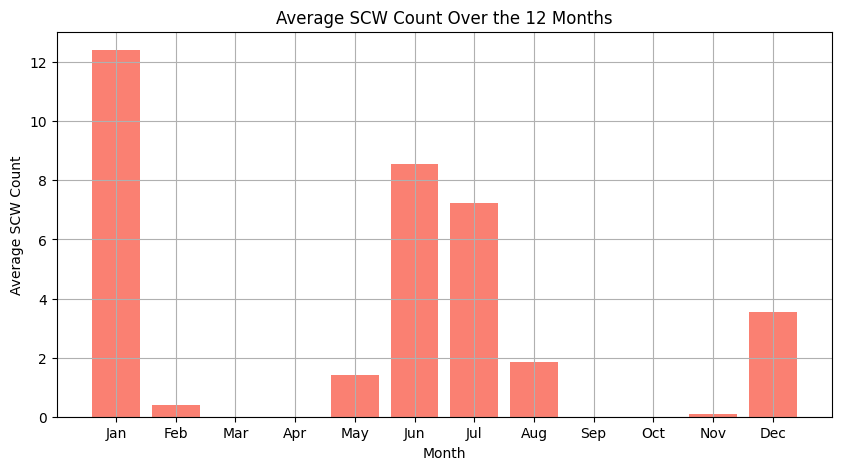

In [6]:
start_dates = [Time(t, format='mjd').datetime for t in scw_start_times]
years = [date.year for date in start_dates]
months = [date.month for date in start_dates]

year_month = [(year, month) for year, month in zip(years, months)]
year_month_count = pd.Series(year_month).value_counts().sort_index()
year_month_labels = [f'{year}-{month:02d}' for year, month in sorted(year_month_count.index)]
scw_year_month_counts = year_month_count.sort_index().values

yearly_count = {year: years.count(year) for year in set(years)}
monthly_count = {month: months.count(month) for month in range(1, 13)}

years_unique = sorted(yearly_count.keys())
scw_yearly = [yearly_count[year] for year in years_unique]

months_unique = list(range(1, 13))
scw_monthly_avg = [monthly_count[month] / len(years_unique) for month in months_unique]

plt.figure(figsize=(12, 6))
plt.bar(year_month_labels, scw_year_month_counts, color='lightgreen')
plt.title('SCW Count Over Months Across Years')
plt.xlabel('Year-Month')
plt.ylabel('Number of SCWs')
plt.xticks(np.arange(0, len(year_month_labels), 12), labels=[year_month_labels[i] for i in range(0, len(year_month_labels), 12)], rotation=45)
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.bar(months_unique, scw_monthly_avg, color='salmon')
plt.title('Average SCW Count Over the 12 Months')
plt.xlabel('Month')
plt.ylabel('Average SCW Count')
plt.xticks(months_unique, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)


In [7]:
epochs = {'start':'2003-01-01', 'stop':'2025-01-01', 'step':'31d'}
jupiter = Horizons(id='sun', location='@599', epochs=epochs) 
eph = jupiter.ephemerides()
ra_values = eph['RA']
dec_values = eph['DEC']
datetime_values = eph['datetime_jd']

jupiter_coords = SkyCoord(ra=ra_values, dec=dec_values, unit=(u.deg, u.deg))

epochs = {'start':'2003-01-01', 'stop':'2025-01-01', 'step':'31d'}
sun = Horizons(id='sun', location='@0', epochs=epochs) 
eph = sun.ephemerides()
ra_values = eph['RA']
dec_values = eph['DEC']

sun_coords = SkyCoord(ra=ra_values, dec=dec_values, unit=(u.deg, u.deg))

years = np.array([eph['datetime_str'][i][:7] for i in range(len(eph))], dtype=str)

In [8]:
angles = sun_coords.separation(jupiter_coords).deg
dates = pd.date_range(start='2003-01-01', periods=260, freq='M')

yearly_avg = [np.mean(angles[i:i+12]) for i in range(0, len(angles), 12)]
monthly_avg = []
for month in range(12):
    month_indices = [i for i in range(len(angles)) if dates[i].month == month + 1]
    monthly_avg.append(np.mean(angles[month_indices]))

/tmp/ipykernel_111030/4246961367.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2003-01-01', periods=260, freq='M')


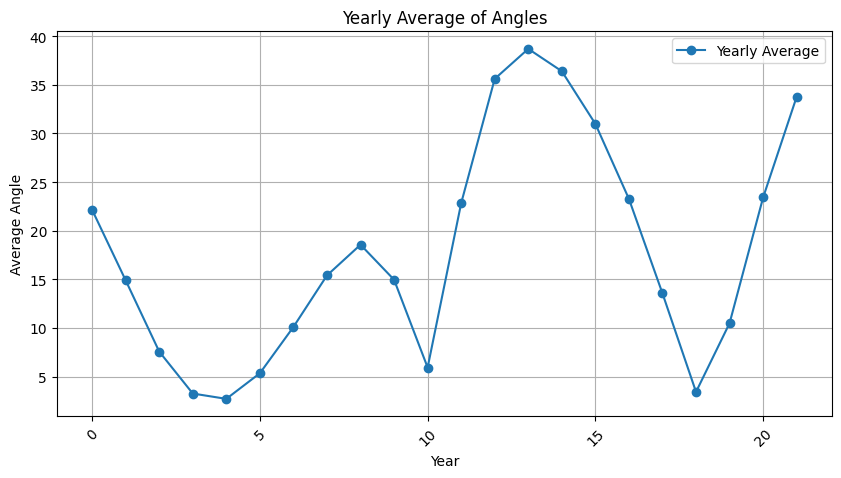

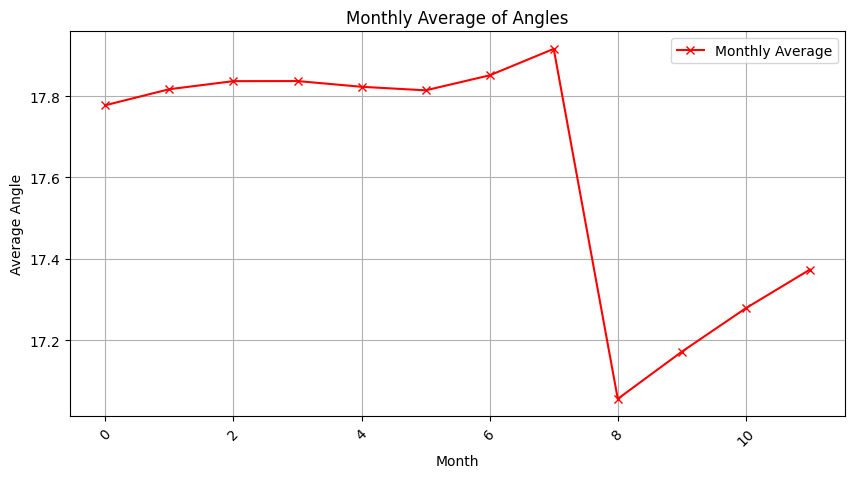

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg, label='Yearly Average', marker='o')
plt.title('Yearly Average of Angles')
plt.xlabel('Year')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg, label='Monthly Average', marker='x', color='r')
plt.title('Monthly Average of Angles')
plt.xlabel('Month')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

## Crab v Sun

In [10]:
scw = []
start = []
end = []

with open("../data/Crab-ScWs.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw.append(parts[0])
        start.append(float(parts[1]))  
        end.append(float(parts[2]))  

unique_sorted_data = {}
for scw, start, end in sorted(zip(scw, start, end), key=lambda x: x[0]):
    if scw not in unique_sorted_data:  
        unique_sorted_data[scw] = (scw, start, end)

scw, start, end = map(list, zip(*unique_sorted_data.values()))
durations = [e-s for e,s in zip(end, start)]

In [11]:
isot_start_times = Time(start, format='mjd').isot
isot_end_times = Time(end, format='mjd').isot
duration_seconds = [duration * 86400 for duration in durations]
year_months = [st[:7] for st in isot_start_times]

Plot distribution of the ScWs over time and the angular seperation between the Crab and the Sun.

In [12]:
crab = SkyCoord.from_name("Crab")
ra = crab.ra.deg
dec = crab.dec.deg
crab_coords = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))

epochs = {'start':'2003-01-01', 'stop':'2025-01-01', 'step':'31d'}
sun = Horizons(id='sun', location='@0', epochs=epochs) 
eph = sun.ephemerides()
ra_values = eph['RA']
dec_values = eph['DEC']
datetime_values = eph['datetime_jd']

sun_coords = SkyCoord(ra=ra_values, dec=dec_values, unit=(u.deg, u.deg))

years = np.array([eph['datetime_str'][i][:7] for i in range(len(eph))], dtype=str)

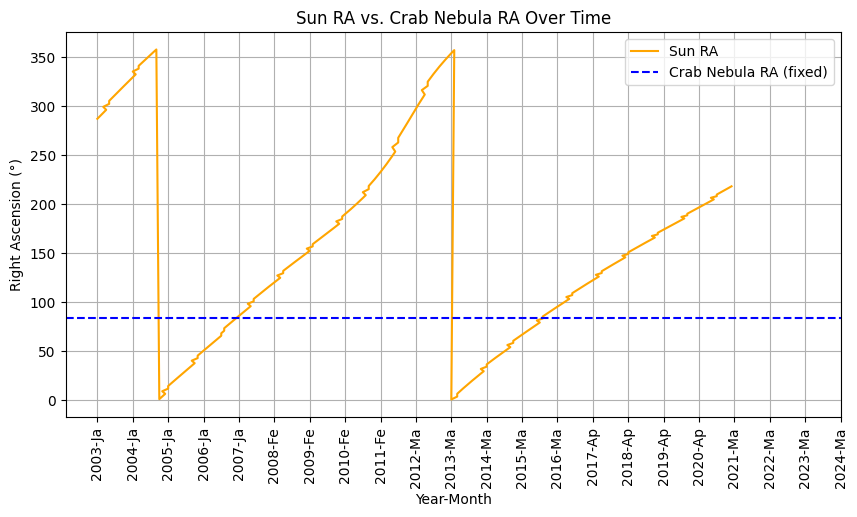

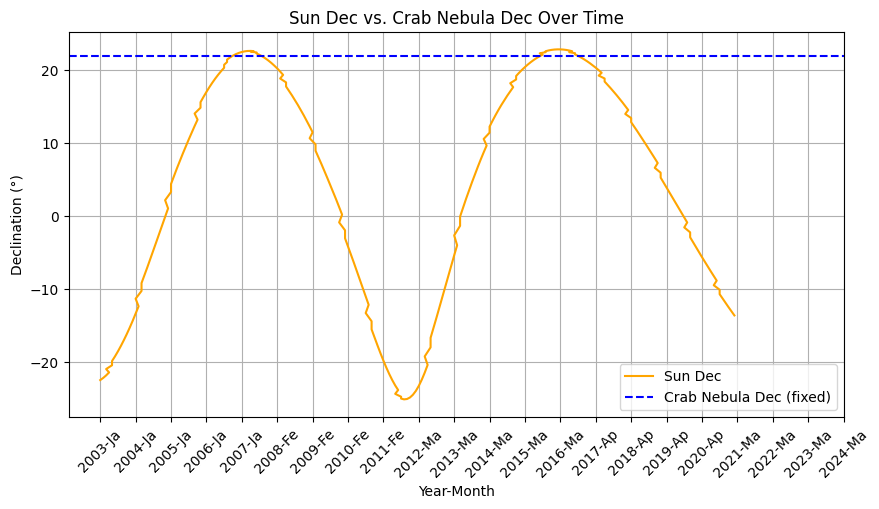

In [13]:
tick_indices = np.arange(0, len(years), 12)
tick_labels = years[tick_indices]

plt.figure(figsize=(10, 5))
plt.plot(years, ra_values, label="Sun RA", color='orange')
plt.axhline(y=ra, color='blue', linestyle='--', label="Crab Nebula RA (fixed)")
plt.xticks(ticks=tick_indices, labels=tick_labels, rotation=90)
plt.xlabel("Year-Month")
plt.ylabel("Right Ascension (°)")
plt.title("Sun RA vs. Crab Nebula RA Over Time")
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(years, dec_values, label="Sun Dec", color='orange')
plt.axhline(y=dec, color='blue', linestyle='--', label="Crab Nebula Dec (fixed)")
plt.xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Declination (°)")
plt.title("Sun Dec vs. Crab Nebula Dec Over Time")
plt.legend()
plt.grid()


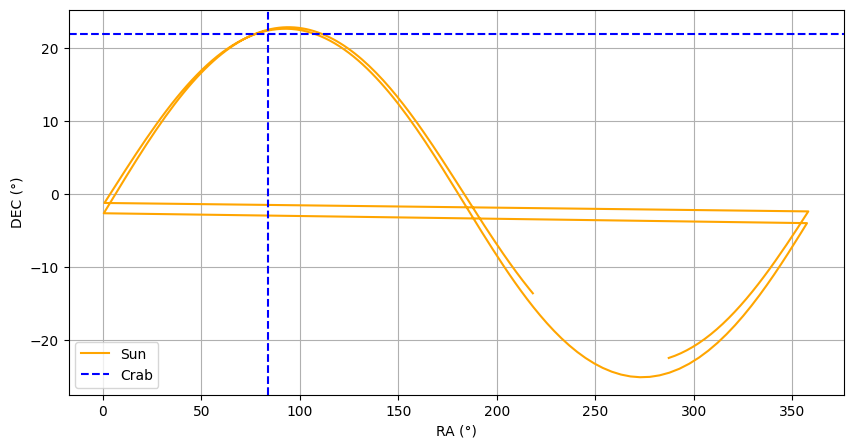

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(ra_values, dec_values, label="Sun", color='orange')
plt.axhline(y=dec, color='blue', linestyle='--', label="Crab")
plt.axvline(x=ra, color='blue', linestyle='--')
plt.xlabel("RA (°)")
plt.ylabel("DEC (°)")
plt.legend()
plt.grid()

In [15]:
angles = sun_coords.separation(crab_coords).deg
dates = pd.date_range(start='2003-01-01', periods=260, freq='M')

yearly_avg = [np.mean(angles[i:i+12]) for i in range(0, len(angles), 12)]
monthly_avg = []
for month in range(12):
    month_indices = [i for i in range(len(angles)) if dates[i].month == month + 1]
    monthly_avg.append(np.mean(angles[month_indices]))

/tmp/ipykernel_111030/3917789146.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2003-01-01', periods=260, freq='M')


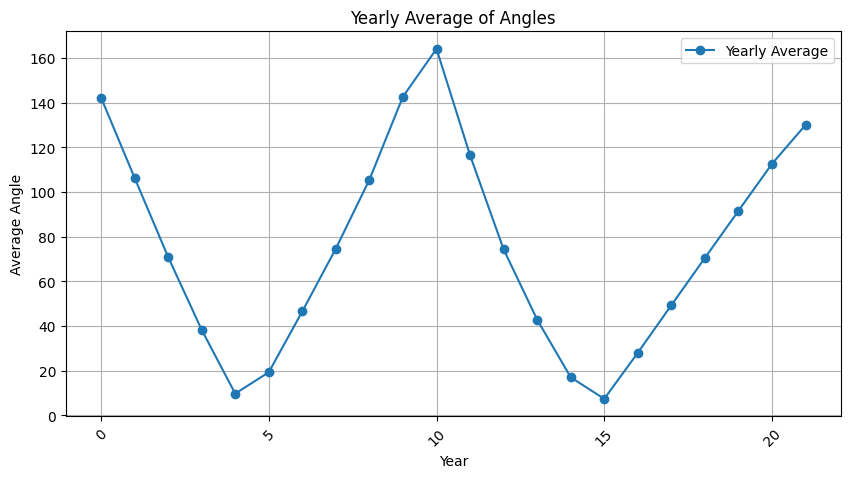

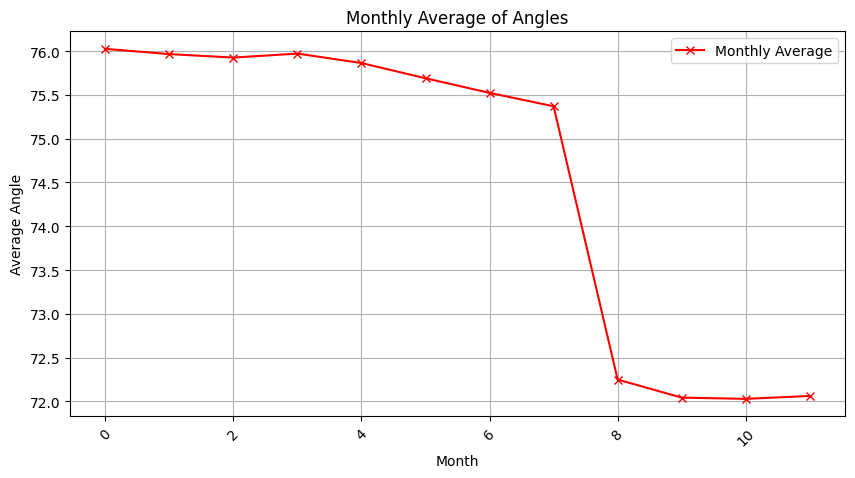

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg, label='Yearly Average', marker='o')
plt.title('Yearly Average of Angles')
plt.xlabel('Year')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg, label='Monthly Average', marker='x', color='r')
plt.title('Monthly Average of Angles')
plt.xlabel('Month')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

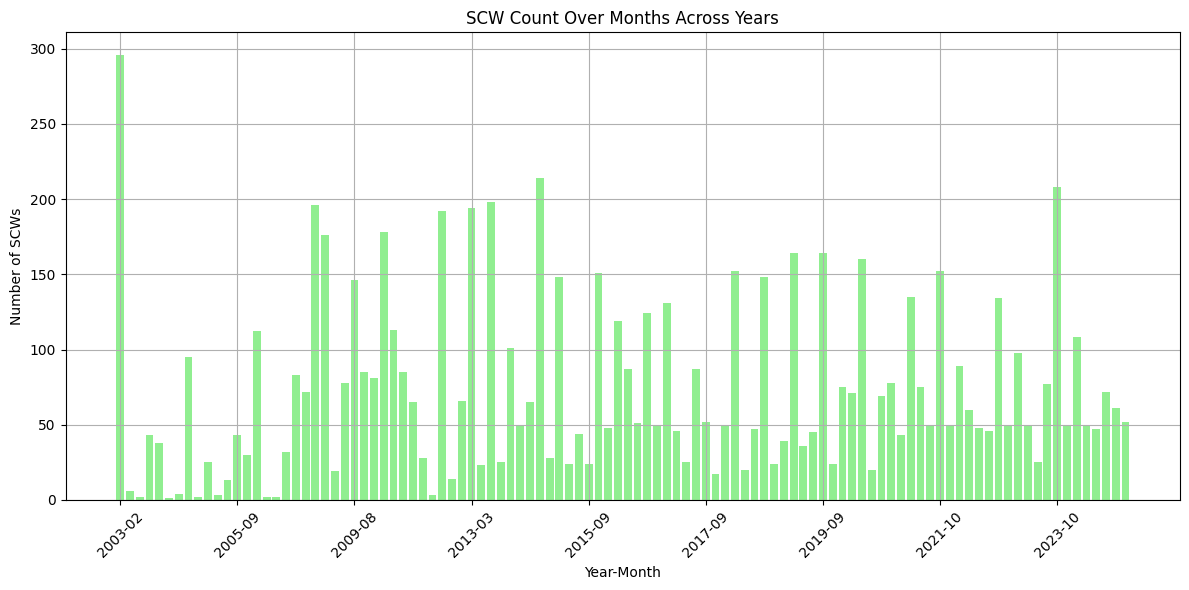

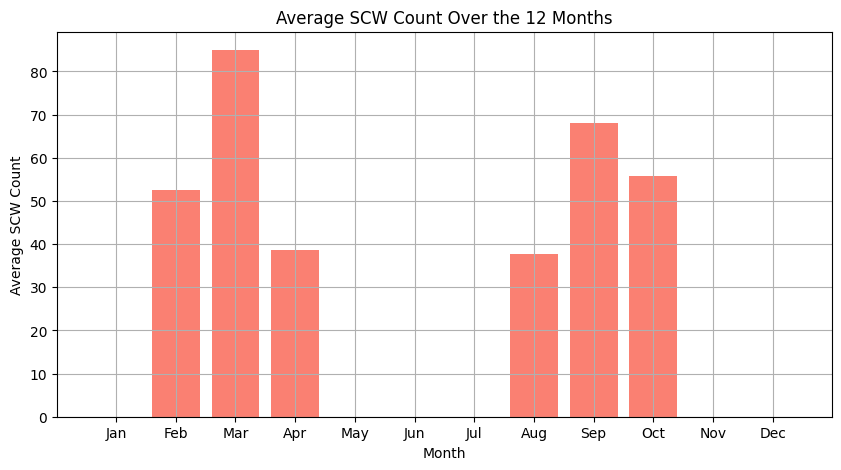

In [17]:
start_dates = [Time(t, format='mjd').datetime for t in start]
years = [date.year for date in start_dates]
months = [date.month for date in start_dates]

year_month = [(year, month) for year, month in zip(years, months)]
year_month_count = pd.Series(year_month).value_counts().sort_index()
year_month_labels = [f'{year}-{month:02d}' for year, month in sorted(year_month_count.index)]
scw_year_month_counts = year_month_count.sort_index().values

yearly_count = {year: years.count(year) for year in set(years)}
monthly_count = {month: months.count(month) for month in range(1, 13)}

years_unique = sorted(yearly_count.keys())
scw_yearly = [yearly_count[year] for year in years_unique]

months_unique = list(range(1, 13))
scw_monthly_avg = [monthly_count[month] / len(years_unique) for month in months_unique]

plt.figure(figsize=(12, 6))
plt.bar(year_month_labels, scw_year_month_counts, color='lightgreen')
plt.title('SCW Count Over Months Across Years')
plt.xlabel('Year-Month')
plt.ylabel('Number of SCWs')
plt.xticks(np.arange(0, len(year_month_labels), 12), labels=[year_month_labels[i] for i in range(0, len(year_month_labels), 12)], rotation=45)
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.bar(months_unique, scw_monthly_avg, color='salmon')
plt.title('Average SCW Count Over the 12 Months')
plt.xlabel('Month')
plt.ylabel('Average SCW Count')
plt.xticks(months_unique, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)


## Check full sky coverage

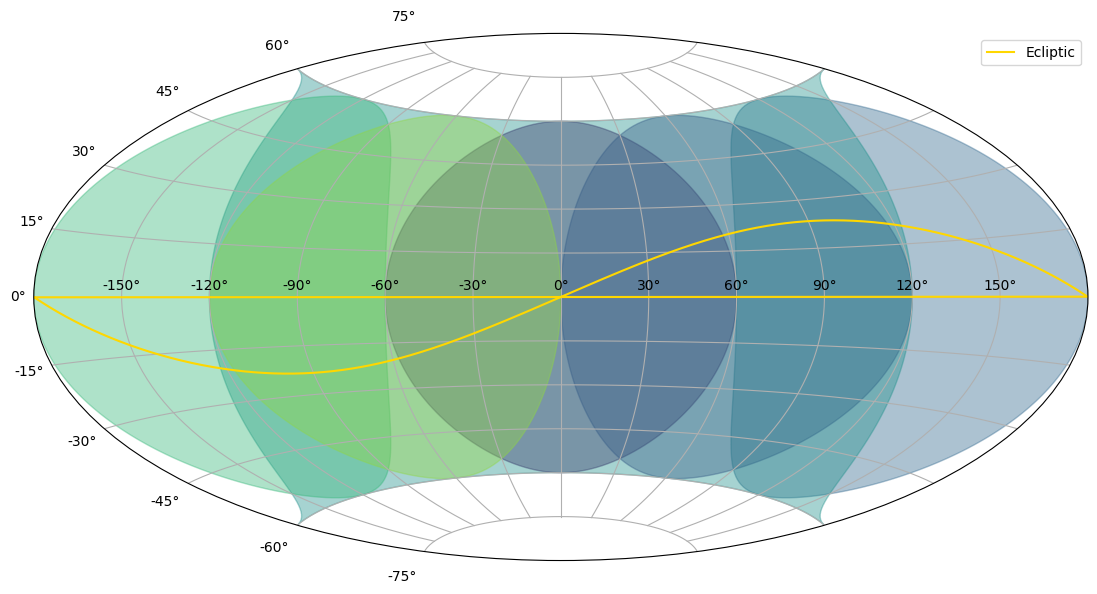

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle, get_body_barycentric, EarthLocation, AltAz, GeocentricTrueEcliptic
from astropy.time import Time
import astropy.units as u

# Define cone centers and radius
centers = [
    (0, 0),  # RA = 0°, Dec = 0°
    (60, 0),  # RA = 60°, Dec = 0°
    (120, 0),  # RA = 120°, Dec = 0°
    (180, 0),  # RA = 180°, Dec = 0°
    (240, 0),  # RA = 240°, Dec = 0°
    (300, 0)  # RA = 300°, Dec = 0°
]

# Define the radius of the cones
radius_deg = 60

# Function to generate the cone boundary
def generate_cone_boundary(ra_center, dec_center, radius_deg, n_points=200):
    center = SkyCoord(ra=ra_center * u.deg, dec=dec_center * u.deg, frame='icrs')
    angle = np.linspace(0, 2 * np.pi, n_points)
    radius = radius_deg * u.deg
    circle_coords = center.directional_offset_by(angle * u.rad, radius)
    ra = circle_coords.ra.wrap_at(180 * u.deg).radian
    dec = circle_coords.dec.radian
    return ra, dec

# Generate the ecliptic in ICRS coordinates
ecliptic_longitudes = Angle(np.linspace(0, 360, 1000), unit=u.deg)
ecliptic = SkyCoord(lon=ecliptic_longitudes, lat=0*u.deg, frame=GeocentricTrueEcliptic)
ecliptic_icrs = ecliptic.transform_to('icrs')
ecliptic_ra = ecliptic_icrs.ra.wrap_at(180*u.deg).radian
ecliptic_dec = ecliptic_icrs.dec.radian

# Plotting
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='aitoff')
ax.grid(True)
#ax.set_title("Sky Coverage with Filled Cones and Ecliptic (Equatorial Coordinates)")

# Plot filled cones
for i, (ra, dec) in enumerate(centers):
    ra_radians, dec_radians = generate_cone_boundary(ra, dec, radius_deg)
    ax.fill(ra_radians, dec_radians, color=plt.cm.viridis(i / len(centers)), alpha=0.4)

# Plot the ecliptic line
ax.plot(ecliptic_ra, ecliptic_dec, color='gold', lw=1.5, label='Ecliptic')

ax.legend(loc='upper right')
plt.tight_layout()

plt.show()


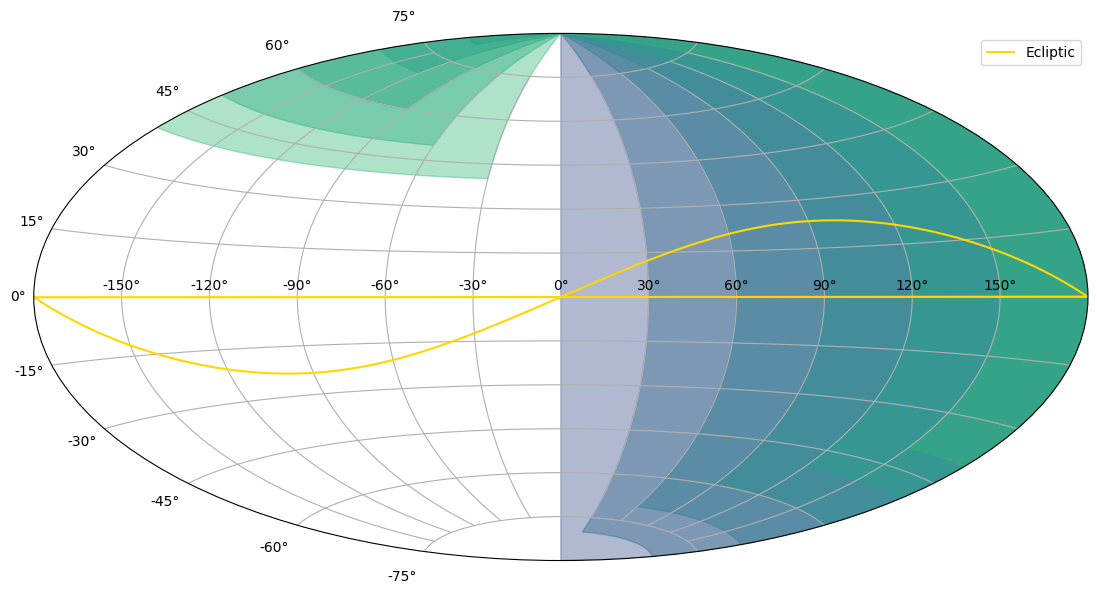

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle, GeocentricTrueEcliptic
import astropy.units as u

# Define cone centers and radius
ras = [
    0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0,
    210.0, 240.0, 270.0, 300.0, 330.0
]
decs = [
    -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0,
    40.0, 50.0, 60.0, 70.0, 80.0, 90.0
]

centers = [
    (ra,dec) for ra, dec in zip(ras, decs)
]

radius_deg = 90

# Function to generate rectangular box boundaries in equatorial coordinates
def generate_box_boundary(ra_center, dec_center, radius_deg, n_points=4):
    # Define box corners in RA, Dec coordinates (approximate)
    ra_min = ra_center - radius_deg
    ra_max = ra_center + radius_deg
    dec_min = dec_center - radius_deg
    dec_max = dec_center + radius_deg

    # Wrap RA values to stay within [0, 360)
    ra_min = ra_min % 360
    ra_max = ra_max % 360

    # Convert to radians for plotting
    ra = np.radians([ra_min, ra_max, ra_max, ra_min])
    dec = np.radians([dec_min, dec_min, dec_max, dec_max])

    return ra, dec

# Generate the ecliptic in ICRS coordinates
ecliptic_longitudes = Angle(np.linspace(0, 360, 1000), unit=u.deg)
ecliptic = SkyCoord(lon=ecliptic_longitudes, lat=0*u.deg, frame=GeocentricTrueEcliptic)
ecliptic_icrs = ecliptic.transform_to('icrs')
ecliptic_ra = ecliptic_icrs.ra.wrap_at(180*u.deg).radian
ecliptic_dec = ecliptic_icrs.dec.radian

# Plotting
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='aitoff')
ax.grid(True)

# Plot filled boxes with unique colors for each center
for i, (ra, dec) in enumerate(centers):
    ra_radians, dec_radians = generate_box_boundary(ra, dec, radius_deg)

    # Handle RA wrapping and plot in two parts if needed
    if ra_radians[0] > ra_radians[1]:  # If box crosses the 0 degree RA boundary
        # First part of the box (from ra_min to 360)
        ra1 = np.concatenate((ra_radians[:2], [np.pi]))  # Wrap the first part of the box
        dec1 = dec_radians[:2]
        
        # Second part of the box (from 0 to ra_max)
        ra2 = np.concatenate(([np.pi], ra_radians[2:]))  # Wrap the second part of the box
        dec2 = dec_radians[2:]
        
        # Close the loop for both parts by adding the first point to the end
        ra1 = np.concatenate((ra1, [ra1[0]]))
        dec1 = np.concatenate((dec1, [dec1[0]]))
        
        ra2 = np.concatenate((ra2, [ra2[0]]))
        dec2 = np.concatenate((dec2, [dec2[0]]))

        # Ensure lengths are equal before plotting
        if len(ra1) == len(dec1) and len(ra2) == len(dec2):
            # Plot the two parts separately
            ax.fill(ra1, dec1, color=plt.cm.viridis(i / len(centers)), alpha=0.4)
            ax.fill(ra2, dec2, color=plt.cm.viridis(i / len(centers)), alpha=0.4)
    else:
        # Otherwise, plot the entire box as normal
        ra_radians = np.concatenate((ra_radians, [ra_radians[0]]))  # Close the loop
        dec_radians = np.concatenate((dec_radians, [dec_radians[0]]))  # Close the loop
        ax.fill(ra_radians, dec_radians, color=plt.cm.viridis(i / len(centers)), alpha=0.4)

# Plot the ecliptic line
ax.plot(ecliptic_ra, ecliptic_dec, color='gold', lw=1.5, label='Ecliptic')

# Add legend
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()
